# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

## Setup

In [1]:
!git clone -b main https://github.com/StarkitRobots/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 490, done.
remote: Total 490 (delta 0), reused 0 (delta 0), pack-reused 490
Receiving objects: 100% (490/490), 60.34 MiB | 19.02 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [2]:
cd cvr_course

/content/cvr_course


In [3]:
import numpy as np
import cv2
import glob
import shapely.geometry as geom
from matplotlib import pyplot as plt

##Task 1

In [4]:
def to_RGB(img):
  return cv2.cvtColor (img, cv2.COLOR_BGR2RGB)

In [5]:
img_files = glob.glob('data/imgs/arrow/*')
len(img_files)


10

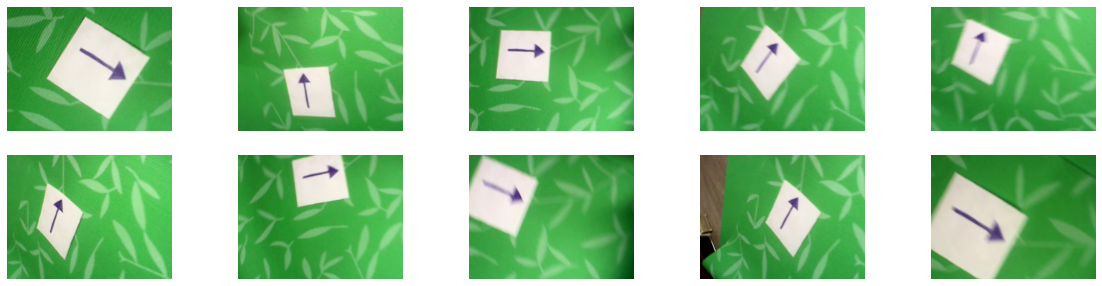

In [6]:
images = []
plt.figure(figsize=(20, 5))
for ind, img_file in enumerate(img_files):
  plt.subplot(2, 5, ind+1)
  img = cv2.imread(img_file)
  images.append(img)
  plt.imshow(to_RGB(img))
  plt.axis('off')
plt.show ()


##Task 2

In [7]:
def find_contour (img, low_th=(200, 200, 200), high_th=(255, 255, 255)):
    mask = cv2.inRange (img, low_th, high_th)
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = None
    max_len = -1
    for contour in contours:
      len = cv2.arcLength(contour, True)
      if len > max_len:
        max_len = len
        cnt = contour

    approx = cv2.convexHull (cnt)
    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)
    return approx

In [8]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)
    contour = find_contour (img, low_th, high_th)
    length = cv2.arcLength (contour, True)
    distance = 180.0 * 364 / length
    return distance

In [9]:
for i in range(len(images)):
  print(i, ") ",  find_distance(images[i]), sep="")

0) 58.213898179172
1) 95.15204916054759
2) 86.98571825076148
3) 91.4181030090751
4) 94.81533612993083
5) 96.64850710230294
6) 92.1951292094964
7) 77.07543760345204
8) 91.934760625742
9) 66.25763790351805


##Task 3

In [10]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
  
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[({0, 1, 2, 3} - {np.argmin(s), np.argmax(s), np.argmin(diff)}).pop()]
    return rect

In [11]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

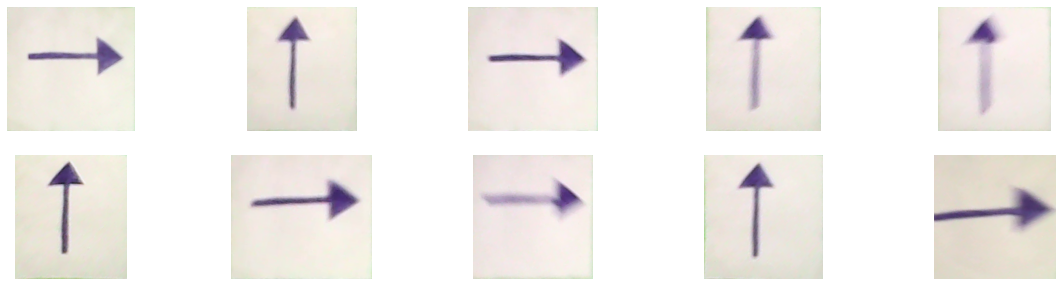

In [12]:
plt.figure(figsize=(20, 5))
for ind in range(len(images)):
  plt.subplot(2, 5, ind+1)
  plt.imshow(to_RGB(four_point_transform (images[ind], np.asarray(find_contour(images[ind], (200, 200, 200),  (255, 255, 255)))[:, 0, :])))
  plt.axis('off')
plt.show ()

##Task 4

In [13]:
def arrow_direction(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  contour = find_contour(img)
  length = cv2.arcLength (contour, True)
  contour = np.reshape(contour, (contour.shape[0], contour.shape[2]))
  edges = cv2.Canny(img_gray, 100, 200)
  lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=10, minLineLength=length/10, maxLineGap=30)
  lines = np.reshape(lines, (lines.shape[0], lines.shape[2]))
  polygon = geom.Polygon(contour)
  for line in lines:
    x1, y1, x2, y2 = line
    if (polygon.contains(geom.Point(x1, y1))) and (polygon.contains(geom.Point(x2, y2))):
      arrow = [[x1, y1], [x2, y2]]
      break
  eps = 35
  average_color_0 = np.mean(img_gray[arrow[0][1] - eps : arrow[0][1] + eps, arrow[0][0] - eps : arrow[0][0] + eps])
  average_color_1 = np.mean(img_gray[arrow[1][1] - eps : arrow[1][1] + eps, arrow[1][0] - eps : arrow[1][0] + eps])
  if average_color_0 < average_color_1:
    arrow.reverse()
  return arrow

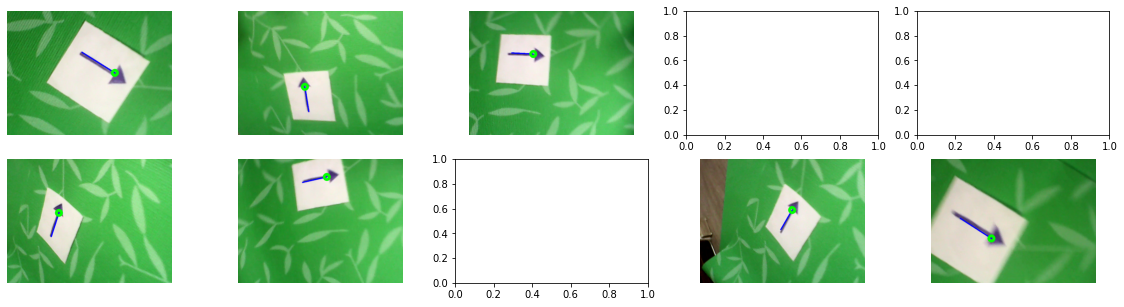

In [14]:
plt.figure(figsize=(20, 5))
for ind in range(len(images)):
  try:
    plt.subplot(2, 5, ind+1)
    arrow = arrow_direction(images[ind])
    cv2.line(images[ind], (arrow[0][0], arrow[0][1]), (arrow[1][0], arrow[1][1]), (255, 0, 0), 3)
    cv2.circle(images[ind], (arrow[1][0], arrow[1][1]), 10,  (0, 255, 0), 10)
    plt.imshow(to_RGB(images[ind]))
    plt.axis('off')
  except:
    pass
plt.show()

Стрелка - синия линия, направление в сторону зеленой точки

Для поиска стрелки ищем отрезки на картике с помощью Хафа, далее выбираем отрезок внутри контура листа бумаги --- этот отрезок пройдет по стрелке. Чтобы найти в каком конце отрезка находится наконечник смотрим на окрестости концов и выбираем более темную. Алгоритм не сработал на смазанных изображениях (1, 2, 9).